# Fairness en Machine Learning: Análisis de Sesgos en Contratación

---
```
author: Cinthya Leonor Vergara Silva
```

** NOTA: ** 

- De acuerdo con la última Encuesta Suplementaria de Ingresos (ESI), elaborada por el Instituto Nacional de Estadísticas (INE), la brecha salarial es de 25,5% en perjuicio de las mujeres para el ingreso promedio. En tanto, respecto de la participación en el mercado laboral, existe una brecha de 19,2 puntos porcentuales en su desmedro, según el informe de desempleo del INE del trimestre marzo-mayo de 2024.

<https://minmujeryeg.gob.cl/?p=54366#:~:text=En%20efecto%2C%20de%20acuerdo%20con,mujeres%20para%20el%20ingreso%20promedio.>

- Datos de Buk y Trabajando muestra que la brecha salarial promedio entre hombres y mujeres en Chile es de un 27%. En Chile, Colombia y Perú, la brecha salarial promedio entre hombres y mujeres es del 26% que corresponde a 555 dólares promedio, Chile es el país con más brecha, seguido por    Perú y Colombia.

<https://info.buk.cl/radiografia-de-las-mujeres-en-el-trabajo-2024>


In [1]:

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Generar datos con 1000 muestras, sesgo en salario por género y edad como variable numérica
df = pd.read_csv('simulacion_contratacion_tech_chile.csv')
# Ver los primeros registros del DataFrame generado
df.head()


,Edad,Genero,NivelEducativo,RamaPrincipal,AñosExperiencia,AñosExperienciaPro,HaTrabajadoCon,PuntajesTecnologias,HabilidadesComputacionales,SalarioAnterior,Puntaje,Contratacion
0,43,Hombre,Técnico,Desarrollo,9,9,Python,1,2.5,1386849.6,1.585520,0
1,29,No Binario,Universitario,Desarrollo,6,6,C++|Node.js|Java,19,5.4,2112758.7,2.327634,1
2,27,Mujer,Universitario,Desarrollo,8,8,Angular,1,2.7,1294771.8,1.469211,0
3,35,Hombre,Técnico,Ciberseguridad,7,7,React,6,2.8,1429358.4,1.592236,0
4,32,Hombre,Magister,Infraestructura,8,4,Python|Node.js|JavaScript|C++,15,4.6,3283509.6,3.006943,1


In [3]:
print("Distribución de empleo por género:")
print(pd.crosstab(df['Genero'], df['Contratacion'], normalize='index'))


Distribución de empleo por género:
Contratacion         0         1
Genero                          
Hombre        0.247163  0.752837
Mujer         0.519892  0.480108
No Binario    0.582031  0.417969


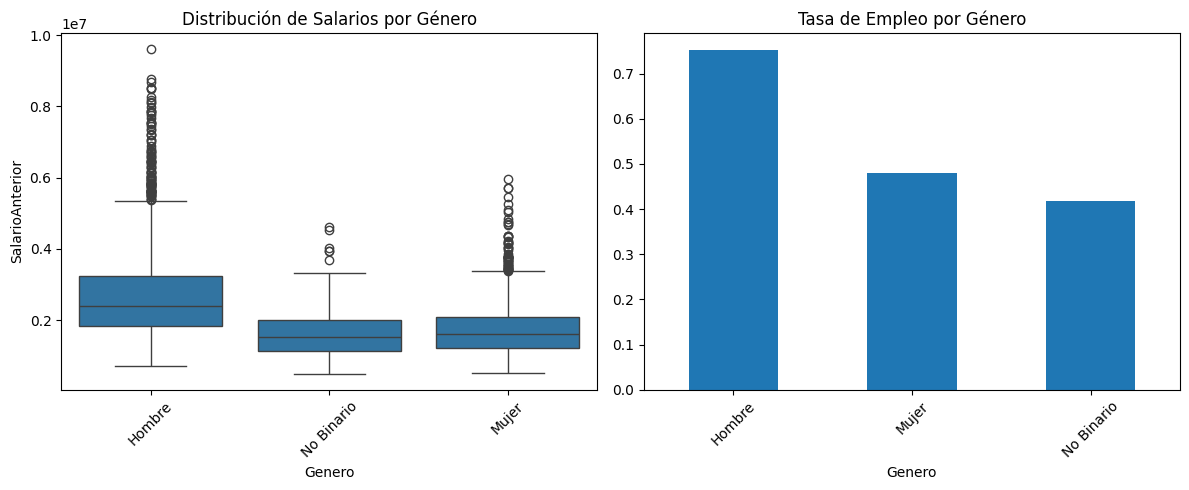

In [4]:
plt.figure(figsize=(12, 5))

# Gráfico de salarios por género
plt.subplot(1, 2, 1)
sns.boxplot(x='Genero', y='SalarioAnterior', data=df)
plt.title('Distribución de Salarios por Género')
plt.xticks(rotation=45)

# Gráfico de tasa de empleo por género
plt.subplot(1, 2, 2)
employment_rate = df.groupby('Genero')['Contratacion'].mean()
employment_rate.plot(kind='bar')
plt.title('Tasa de Empleo por Género')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


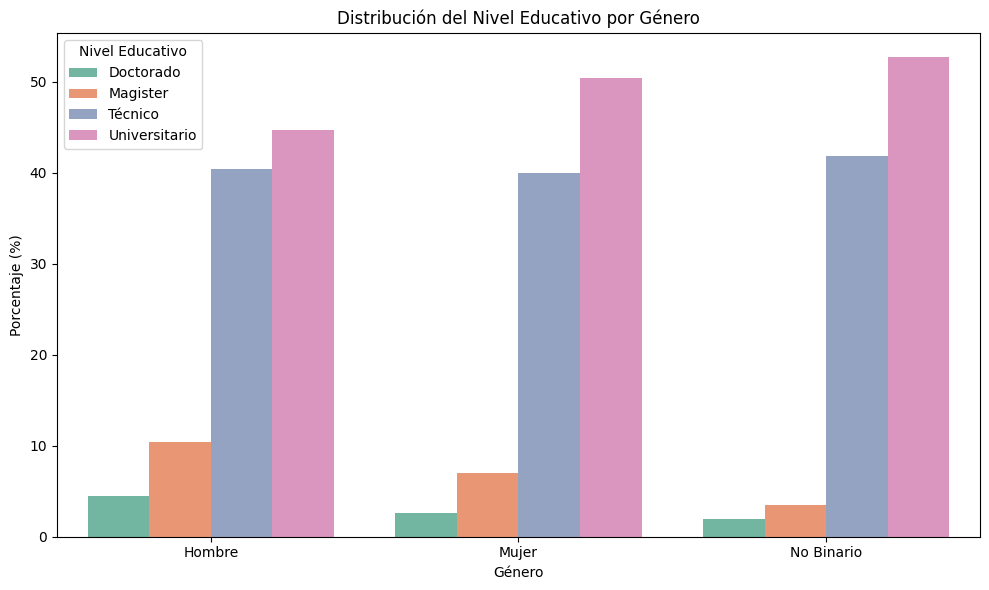

In [5]:
# 1. Calcular la distribución de Nivel Educativo por Género
edu_genero_counts = df.groupby(['Genero', 'NivelEducativo']).size().reset_index(name='Count')

# 2. Calcular el porcentaje por género y nivel educativo
edu_genero_counts['Percentage'] = edu_genero_counts.groupby('Genero')['Count'].transform(lambda x: x / x.sum() * 100)

# 3. Crear el gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Genero', y='Percentage', hue='NivelEducativo', data=edu_genero_counts, palette="Set2")

# 4. Añadir título y etiquetas
plt.title('Distribución del Nivel Educativo por Género')
plt.xlabel('Género')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Nivel Educativo')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [6]:
# Preparar características y objetivo
X = pd.get_dummies(df, drop_first=True)
y = df['Contratacion'].astype(int)  # Convertir 'Empleo' a tipo entero (0, 1)

# Separar datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar la variable sensible (género)
caracteristica_sensible = X_train['Genero_Mujer']
caracteristica_sensible_test = X_test['Genero_Mujer']

# Escalar características numéricas
escalador = StandardScaler()

# Seleccionar columnas numéricas
columnas_numericas = X.select_dtypes(include=['int64', 'float64']).columns

# Escalar las columnas numéricas en X_train y X_test
X_train[columnas_numericas] = escalador.fit_transform(X_train[columnas_numericas])
X_test[columnas_numericas] = escalador.transform(X_test[columnas_numericas])


# 4. Modelado Base

--- 

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Preparar las características y el objetivo
X = df.drop(columns=['Puntaje','Contratacion','HaTrabajadoCon'])  # Excluir 'Empleo' de las características
X = pd.get_dummies(X, drop_first=True)
y = df['Contratacion'].astype(int)  # Asegúrate de que 'Empleo' sea 0 o 1

# 2. Asegurar que no haya valores nulos en las características y en el objetivo
#X = X.fillna(0)  # Rellenar valores nulos en las características con 0
#y = y.fillna(0)  # Rellenar valores nulos en el objetivo con 0

# 3. Convertir las variables booleanas a enteros
X = X.astype(int)

# 4. Separar los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Escalar las características numéricas
escalador = StandardScaler()
columnas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
X_train[columnas_numericas] = escalador.fit_transform(X_train[columnas_numericas])
X_test[columnas_numericas] = escalador.transform(X_test[columnas_numericas])

# 7. Convertir X_train y X_test a matrices Numpy
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# 8. Añadir una constante a las características (intercepto)
X_train_sm = sm.add_constant(X_train_np)
X_test_sm = sm.add_constant(X_test_np)

# 9. Modelo logístico 
modelo_logistico_base = sm.Logit(y_train, X_train_sm)
resultado_base = modelo_logistico_base.fit()

# 10. Predicción y evaluación del modelo base
y_pred_base_sm = (resultado_base.predict(X_test_sm) > 0.5).astype(int)

# Mostrar el resumen del modelo
print(resultado_base.summary())


Optimization terminated successfully.
         Current function value: 0.153722
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           Contratacion   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3984
Method:                           MLE   Df Model:                           15
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.7607
Time:                        20:11:47   Log-Likelihood:                -614.89
converged:                       True   LL-Null:                       -2569.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4673      0.299     14.920      0.000       3.880       5.054
x1            -0.2058      0

In [8]:
X.columns

Index(['Edad', 'AñosExperiencia', 'AñosExperienciaPro', 'PuntajesTecnologias',
       'HabilidadesComputacionales', 'SalarioAnterior', 'Genero_Mujer',
       'Genero_No Binario', 'NivelEducativo_Magister',
       'NivelEducativo_Técnico', 'NivelEducativo_Universitario',
       'RamaPrincipal_Ciberseguridad', 'RamaPrincipal_Desarrollo',
       'RamaPrincipal_Infraestructura', 'RamaPrincipal_Soporte'],
      dtype='object')

# 5. Modelo sin Variable de Género

--- 


In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Preparar las características y el objetivo
X = df.drop(columns=['Puntaje','Contratacion','HaTrabajadoCon','Genero'])  # Excluir 'Empleo' de las características
X = pd.get_dummies(X, drop_first=True)
y = df['Contratacion'].astype(int)  # Asegúrate de que 'Empleo' sea 0 o 1

# 2. Convertir las variables booleanas a enteros
X = X.astype(int)

# 3. Separar los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Escalar las características numéricas
escalador = StandardScaler()
columnas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
X_train[columnas_numericas] = escalador.fit_transform(X_train[columnas_numericas])
X_test[columnas_numericas] = escalador.transform(X_test[columnas_numericas])

# 5. Convertir X_train y X_test a matrices Numpy
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# 6. Añadir una constante a las características (intercepto)
X_train_sm = sm.add_constant(X_train_np)
X_test_sm = sm.add_constant(X_test_np)

# 7. Modelo logístico 
modelo_logistico_sg = sm.Logit(y_train, X_train_sm)
resultado_base = modelo_logistico_base.fit()

# 8. Predicción y evaluación del modelo base
y_pred_base_sm = (resultado_base.predict(X_test_sm) > 0.5).astype(int)

# Mostrar el resumen del modelo
print(resultado_base.summary())


Optimization terminated successfully.
         Current function value: 0.153722
         Iterations 11


ValueError: shapes (1000,14) and (16,) not aligned: 14 (dim 1) != 16 (dim 0)

In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

# 1. Preparar los datos
X = df.drop(columns=['Puntaje', 'Contratacion', 'HaTrabajadoCon'])  # Excluir columnas irrelevantes
X = pd.get_dummies(X, drop_first=True)
y = df['Contratacion'].astype(int)  # Convertir el objetivo a binario

# 2. Identificar las variables sensibles
columnas_sensibles = [col for col in X.columns if 'Genero' in col]  # Por ejemplo, 'Genero_Mujer'
sensible_indices = [X.columns.get_loc(col) for col in columnas_sensibles]  # Índices de las columnas sensibles

# 3. Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Añadir una constante
X_scaled = sm.add_constant(X_scaled)

# 5. Definir la función de log-verosimilitud penalizada
def penalized_fairness_log_likelihood(params, X, y, alpha, sensible_indices):
    """
    Log-verosimilitud penalizada para equidad.
    Penaliza solo los coeficientes asociados a variables sensibles.
    """
    # Calcular predicciones logísticas
    linear_combination = np.dot(X, params)
    prob = sm.families.Binomial().link.inverse(linear_combination)
    
    # Log-verosimilitud
    log_likelihood = np.sum(y * np.log(prob) + (1 - y) * np.log(1 - prob))
    
    # Penalización en coeficientes sensibles
    penalty = alpha * np.sum(params[sensible_indices] ** 2)
    
    return -1 * (log_likelihood - penalty)  # Negativo para minimizar

# 6. Optimizar el modelo usando scipy.optimize.minimize
alpha = 1.0  # Factor de penalización para equidad
initial_params = np.zeros(X_scaled.shape[1])

result = minimize(
    penalized_fairness_log_likelihood,
    x0=initial_params,
    args=(X_scaled, y, alpha, sensible_indices),
    method='L-BFGS-B'
)

# Parámetros optimizados
optimal_params = result.x

# 7. Predicción en el conjunto de datos
linear_combination = np.dot(X_scaled, optimal_params)
probabilities = sm.families.Binomial().link.inverse(linear_combination)
y_pred = (probabilities > 0.5).astype(int)

# 8. Evaluar precisión y métricas de equidad
from sklearn.metrics import accuracy_score, confusion_matrix

# Precisión general
accuracy = accuracy_score(y, y_pred)
print(f"Precisión del modelo penalizado: {accuracy}")

# Evaluar disparidad en sensibilidad y especificidad entre grupos
sensitive_column = X['Genero_Mujer']  # Ajusta según tu variable
grupo_0 = sensitive_column == 0
grupo_1 = sensitive_column == 1

# Calcular métricas por grupo
for grupo, mascara in zip(['Hombres', 'Mujeres'], [grupo_0, grupo_1]):
    y_grupo = y[mascara]
    y_pred_grupo = y_pred[mascara]
    tn, fp, fn, tp = confusion_matrix(y_grupo, y_pred_grupo).ravel()
    print(f"Métricas para {grupo}:")
    print(f"  Tasa de verdaderos positivos (TPR): {tp / (tp + fn):.2f}")
    print(f"  Tasa de falsos positivos (FPR): {fp / (fp + tn):.2f}")


Precisión del modelo penalizado: 0.9328
Métricas para Hombres:
  Tasa de verdaderos positivos (TPR): 0.96
  Tasa de falsos positivos (FPR): 0.12
Métricas para Mujeres:
  Tasa de verdaderos positivos (TPR): 0.92
  Tasa de falsos positivos (FPR): 0.07


In [13]:
import pandas as pd

# Crear la tabla con los resultados
tabla_resultados = pd.DataFrame({
    'Coeficiente': optimal_params,  # Coeficientes estimados
    'Nombre de la variable': ['Constante'] + list(X.columns),  # Nombres de las variables (incluyendo la constante)
})


# Mostrar la tabla
print(tabla_resultados)


    Coeficiente          Nombre de la variable
0      4.116912                      Constante
1     -0.145038                           Edad
2      0.847205                AñosExperiencia
3     -0.710074             AñosExperienciaPro
4     -0.086058            PuntajesTecnologias
5      6.930362     HabilidadesComputacionales
6      0.608300                SalarioAnterior
7     -1.794573                   Genero_Mujer
8     -1.047769              Genero_No Binario
9      0.110101        NivelEducativo_Magister
10    -1.493895         NivelEducativo_Técnico
11    -0.631583   NivelEducativo_Universitario
12     0.122038   RamaPrincipal_Ciberseguridad
13    -0.698989       RamaPrincipal_Desarrollo
14    -1.125061  RamaPrincipal_Infraestructura
15    -1.990275          RamaPrincipal_Soporte
